<h1>Analysis 3 - Time series analysis</h1>

This is based on Shaohua Liu workbook Analysis 2 (20/5/2021)

<h2>Section 1 - Preprocessing</h2>

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import requests
import json
import seaborn as sns

In [2]:
def parse_CL(site):
    df = pd.concat([pd.read_csv(file) for file in glob(f'Ceilometer/*{site}.csv')])

    # replace -999 to NaN
    df = df.replace(-999, np.nan)

    # parse date string
    df['# Time'] = pd.to_datetime(df['# Time'], format='%d/%m/%Y %H:%M:%S')
    
    # interpolate bl_height by time
    df['revised_bl_height'] = df.set_index('# Time')['bl_height'].interpolate(method='time').values

    # aggregate bl_height by hourly average
    df = df.groupby([
        df['# Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['# Time'].dt.hour.rename('Hour')
    ])['revised_bl_height'].mean().reset_index(name='CL_BLH').set_index(['Date', 'Hour'])

    return df

In [3]:
def parse_CTM(site, time_offset=10):
    # Careful! The seperator is not ',' but ', ' (space)
    df = pd.concat([pd.read_csv(file, sep=r'\s*,\s*', engine='python') for file in glob(f'CTM_ModelOutput/*{site}.csv')])

    # parse date string
    from datetime import timedelta
    df['Time'] = pd.to_datetime(df[['date', 'time']].astype(str).apply('-'.join, 1), format='%Y%m%d-%H') + timedelta(hours=time_offset)

    df = df.groupby([
        df['Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['Time'].dt.hour.rename('Hour')
    ])['mixing_height'].mean().reset_index(name='CTM_BLH').set_index(['Date', 'Hour'])

    return df

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def join_CL_CTM(site):
    CLdf = parse_CL(site)
    CTMdf = parse_CTM(site)
    return CLdf.join(CTMdf, how='inner')

def bl_plot(site):
    join_df = join_CL_CTM(site).reset_index()
    join_df['Time'] = pd.to_datetime(join_df[['Date', 'Hour']].astype(str).apply('-'.join, 1), format='%Y-%m-%d-%H')
    join_df.plot(x='Time', y=['CTM_BLH', 'CL_BLH'], title=site)
    plt.show()

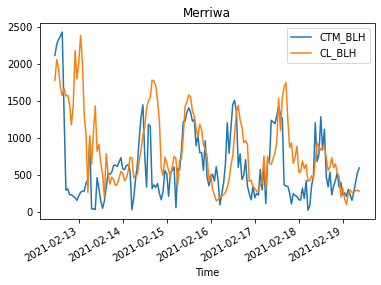

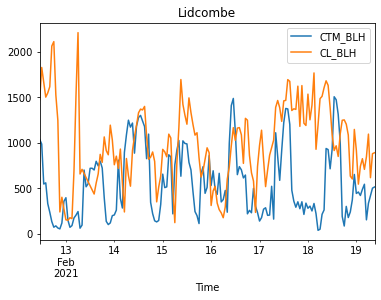

In [5]:
bl_plot('Merriwa')
bl_plot('Lidcombe')

In [5]:
class AQMS_API:
    def __init__(self):
        self.url_prefix = 'https://data.airquality.nsw.gov.au/api/Data/'
        self.headers = {
            'content-type': 'application/json',
            'accept': 'application/json',
        }
        
        self.site_url = 'get_SiteDetails'
        self.parameter_url = 'get_ParameterDetails'
        self.observation_url = 'get_Observations'
        
    def get_data(self, url_suffix, http_method=requests.get, data=None):
        query = self.url_prefix + url_suffix
        response = http_method(url=query, headers=self.headers, json=data)
        return response.json()
    
    def get_sites(self):
        return self.get_data(self.site_url)
    
    def get_parameters(self):
        return self.get_data(self.parameter_url)
    
    def get_observations(self, data=None):
        return self.get_data(self.observation_url, requests.post, data)

# historical observation query builder
def obs_builder(parameter=None, sites=None, start=None, end=None, category=None, sub_category=None, freq=None):
    '''
    start & end : '%Y-%m-%d' format date string
    '''
    def list_parser(s):
        if s is None or isinstance(s, list):
            return s
        else:
            return [s]

    return {
        'Parameters': list_parser(parameter),
        'Sites': list_parser(sites),
        'StartDate': start,
        'EndDate': end,
        'Categories': list_parser(category),
        'SubCategories': list_parser(sub_category),
        'Frequency': list_parser(freq),
    }

In [6]:
api = AQMS_API()

# site id
sites = {
    'Merriwa': 329,
    'Lidcombe': 1141,
}

In [7]:
df = pd.DataFrame.from_records(api.get_parameters())
params = df.loc[
    (df['Category'] == 'Averages') & 
    (df['SubCategory'] == 'Hourly') & 
    (df['Frequency'] == 'Hourly average')
]
#params

In [8]:
#TK 28/7/2021: Added BL diff - can/should we use this as a feature..?
def bl_external(site, site_id):
    query = obs_builder(
        params['ParameterCode'].tolist(), 
        site_id, 
        '2021-02-12',
        '2021-02-19',
        'Averages', 
        'Hourly', 
        'Hourly average'
    )
    obs = pd.DataFrame.from_records(api.get_observations(query))
    obs['Hour'] = obs['Hour'] - 1
    obs['Parameter'] = pd.json_normalize(obs['Parameter'])['ParameterDescription']
    obs = pd.pivot(obs, index=['Date', 'Hour'], columns='Parameter', values='Value').reset_index()
    df = join_CL_CTM(site).join(obs.set_index(['Date', 'Hour']), how='inner').reset_index()
    df['BL_diff'] =df['CL_BLH'] - df['CTM_BLH'] 
    return df

In [9]:
#df = bl_external('Merriwa', 329)
#df

In [9]:
data = {site: bl_external(site, id) for site, id in sites.items()}

<h2>Section 2 - Correlation analysis</h2>

In [11]:
def get_df(site):
    if site == 'all':
        df = pd.concat(data.values()).drop(columns='Solar radiation')
    else:
        df = data[site]
    return df.dropna().set_index(['Date', 'Hour'])

def corr(site, method='pearson'):
    return get_df(site).corr(method=method)

from scipy.stats import pearsonr

def p_value(site):
    df = get_df(site)._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 6)
    return pvalues

In [11]:
corr('all', 'pearson').iloc[:, :2]

,CL_BLH,CTM_BLH
CL_BLH,1.000000,0.287952
CTM_BLH,0.287952,1.000000
Carbon monoxide,0.092702,-0.184646
Humidity,-0.667230,-0.518442
Nephelometer,0.006918,-0.173402
Nitric Oxide,0.144480,-0.125607
Nitrogen Dioxide,0.011283,-0.424918
Ozone,0.468203,0.455442
PM10,0.352813,-0.023971
PM2.5,0.017452,-0.217491


In [14]:
p_value('all').iloc[:, :2]

,CL_BLH,CTM_BLH
CL_BLH,0.0,0.000001
CTM_BLH,0.000001,0.0
Carbon monoxide,0.125132,0.002108
Humidity,0.0,0.0
Nephelometer,0.909081,0.003923
Nitric Oxide,0.016502,0.037367
Nitrogen Dioxide,0.852237,0.0
Ozone,0.0,0.0
PM10,0.0,0.692281
PM2.5,0.773255,0.000279


In [15]:
# available method [‘pearson’, ‘kendall’, ‘spearman’]
corr('Lidcombe', 'pearson').iloc[:, :2]

,CL_BLH,CTM_BLH
CL_BLH,1.000000,0.136481
CTM_BLH,0.136481,1.000000
Carbon monoxide,-0.284860,-0.460941
Humidity,-0.576953,-0.437755
Nephelometer,-0.313251,-0.311381
Nitric Oxide,0.152507,-0.249707
Nitrogen Dioxide,-0.013995,-0.600630
Ozone,0.328640,0.399086
PM10,0.138696,-0.119004
PM2.5,-0.148077,-0.148062


In [16]:
p_value('Lidcombe').iloc[:, :2]

,CL_BLH,CTM_BLH
CL_BLH,0.0,0.140567
CTM_BLH,0.140567,0.0
Carbon monoxide,0.001769,0.0
Humidity,0.0,0.000001
Nephelometer,0.000553,0.000599
Nitric Oxide,0.099213,0.006392
Nitrogen Dioxide,0.880438,0.0
Ozone,0.00028,0.000008
PM10,0.134177,0.19931
PM2.5,0.109546,0.109581


In [17]:
corr('Merriwa', 'pearson').iloc[:, :2]

,CL_BLH,CTM_BLH
CL_BLH,1.000000,0.395865
CTM_BLH,0.395865,1.000000
Carbon monoxide,0.522859,0.200391
Humidity,-0.755757,-0.597379
Nephelometer,-0.128754,-0.089435
Nitric Oxide,0.052930,0.150851
Nitrogen Dioxide,-0.104132,-0.312676
Ozone,0.695825,0.497777
PM10,0.475645,0.091247
PM2.5,0.078824,-0.245054


In [18]:
p_value('Merriwa').iloc[:, :2]

,CL_BLH,CTM_BLH
CL_BLH,0.0,0.0
CTM_BLH,0.0,0.0
Carbon monoxide,0.0,0.011856
Humidity,0.0,0.0
Nephelometer,0.108036,0.265323
Nitric Oxide,0.510299,0.059313
Nitrogen Dioxide,0.194331,0.000067
Ozone,0.0,0.0
PM10,0.0,0.255725
PM2.5,0.326444,0.00198


<h2>Section 3 - TS models</h3>

<span style= "color:red">
TK thoughts - 29/7/2021:
<ul>
    <li>Try combi of ML and more traditional TS models</li>
    <li>Need to research more about ARIMA models</li>
    <li>May utilise prophet</li>
</ul>

I see this as two issues: (1) What factors are relevant in the ARIMA model and (2) how to parameterise the ARIMA model.
</span>

<h4>Data config</h4>

In [10]:
#Get data from dict
df_merriwa = data['Merriwa']
df_lidcombe = data['Lidcombe']

#sanity check
#df_merriwa

In [11]:
'''
There are NaNs in external factors. Just fill them in. This as opposed to dropping data with missing values
'''
def interpolate_external_factors(df):

    df['datetime'] = pd.to_datetime(df['Date'] +' '+ df['Hour'].astype(str)+':00', format = '%Y-%m-%d %H:%M')

    feature_list_all = [feature for feature in df.columns][4:len(df.columns)-2]

    for feature in feature_list_all:
        df[feature] = df.set_index('datetime')[feature].interpolate(method='time').values
        
    return df

In [12]:
df_merriwa_filled = interpolate_external_factors(df_merriwa)
df_lidcombe_filled = interpolate_external_factors(df_lidcombe)

In [61]:
df_merriwa_filled.shape

(166, 20)

In [62]:
df_lidcombe_filled.shape

(167, 21)

In [75]:
df_lidcombe_filled.isnull().sum()

Date                          0
Hour                          0
CL_BLH                        0
CTM_BLH                       0
Carbon monoxide               0
Humidity                      0
Nephelometer                  0
Nitric Oxide                  0
Nitrogen Dioxide              0
Ozone                         0
PM10                          0
PM2.5                         0
Rainfall                      0
Solar radiation               0
Sulphur Dioxide               0
Temperature                   0
Wind Direction (10m)          0
Wind Direction Sigma Theta    0
Wind Speed (10m)              0
BL_diff                       0
datetime                      0
dtype: int64

In [11]:
'''
Not really used - just for curiosity
'''
#Split data
#df_merriwa_cl = df_merriwa.drop(columns = ['CTM_BLH','BL_diff'])
#df_lidcombe_cl = df_lidcombe.drop(columns = ['CTM_BLH','BL_diff'])

#sanity check
#df_merriwa_cl

<h5>Defining the statistical comparison measures - as per analysis 1</h5>

In [13]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [14]:
'''
Stolen from: https://github.com/rkawsar/ambhas/blob/master/ambhas/errlib.py

This basically looks like a modified version of R2?
'''

def index_agreement(s, o):
    """
    index of agreement

    Willmott (1981, 1982) 
    input:
        s: simulated
        o: observed
    output:
        ia: index of agreement
    """
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia

In [15]:
'''
Calculate mean bias error
'''
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)


In [16]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def DTW_dist(y_true, y_pred):
    distance, path = fastdtw(y_true, y_pred, dist=euclidean)
    
    return distance, path

In [17]:
'''
Function: Calculates and prints out the varoius metrics
'''

def satistical_comps_on_df(y_true, y_pred, location):    
    y_true = y_true.to_numpy()
    y_pred = y_pred.to_numpy()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    ioa = index_agreement(y_pred, y_true)
    dtw_dist, path = DTW_dist(y_true, y_pred)
    
    print('At %s\nIndex of agreement:%.5f\nRoot mean squared error:%.5f\nMean absoluate error:%.5f\nMean bias error:%.5f\nDTW distance:%.2f' % (location, ioa, rmse, mae, mbe, dtw_dist))

<h5>Base comp stats and plots - assuming gold standard is CT model</h5>

In [73]:
satistical_comps_on_df(df_merriwa_filled.tail(24)['CL_BLH'], df_merriwa_filled.tail(24)['CTM_BLH'], 'Merriwa CTM model')

At Merriwa CTM model
Index of agreement:0.83320
Root mean squared error:212.95909
Mean absoluate error:171.77558
Mean bias error:-21.58962
DTW distance:3611.44


In [74]:
satistical_comps_on_df(df_lidcombe_filled.tail(24)['CL_BLH'], df_lidcombe_filled.tail(24)['CTM_BLH'], 'Lidcombe CTM model')

At Lidcombe CTM model
Index of agreement:0.39774
Root mean squared error:585.35820
Mean absoluate error:505.07921
Mean bias error:-375.16142
DTW distance:12043.29


<h4> Stationarity checks</h4>

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
#Augmented Dicky Fuller test for stationarity
#H0: Process is not stationary

def adf_test(series):
    adf_test_result = adfuller(series)
    print('ADF stat %0.5f' % adf_test_result[0])
    print('p-val %0.5f' % adf_test_result[1])

In [19]:
adf_test(df_merriwa['CL_BLH'])

ADF stat -3.90056
p-val 0.00203


In [20]:
adf_test(df_lidcombe['CL_BLH'])

ADF stat -4.78602
p-val 0.00006


Looks stationary..

<h5>Train test split and feature list</h5>

Use last 24 hours as test

In [18]:
feature_list = ['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Ozone',
 'Temperature',
 'Wind Direction Sigma Theta']

In [77]:
feature_list_all = [feature for feature in df_merriwa.columns][4:len(df_merriwa.columns)-2]

<h5>Generic modelling functions</h5>

In [36]:
'''
Define a generic modeller function

Inputs:
- df: dataframe object
- feature_list: list of features
- target: target variable
- modeller: base model to fit

Returns:
- df_result: dataframe of results

'''
def modeller(df, feature_list, target, modeller):
    '''
    Define train test split
    '''
    train = df.head(142)
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    '''
    Train model
    '''
    modeller.fit(X_train, y_train)

    '''
    Predict
    '''
    modeller_predict = modeller.predict(X_test)
    
    '''
    Write to dataframe
    '''
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  modeller_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    return df_result


In [43]:
def pred_plots(df, title):
    resid_plot_title = 'Residual plots at '+ title
    pred_plot_title = 'Comparison of predicted BLH at ' + title
    
    sns.set_theme(style="whitegrid")

    # Make an example dataset with y ~ x
    x = df['CL_BLH']
    y = df['Predicted BLH']

    # Plot the residuals after fitting a linear model
    sns.residplot(x=x, y=y, lowess=True, color="g").set(title = resid_plot_title)
    df.plot(title = pred_plot_title)

In [45]:
def results_print(df, title):
    pred_plots(df, title)
    satistical_comps_on_df(df['CL_BLH'], df['Predicted BLH'], title)

<h3>GBM methods</h3>

The idea is to use boosting methods as applied to time series based on feature set to develop an ensemble model. Will use linear regressors

4/8/2021 - General thoughts
* BM seem to work OK
* There are many different algos though - each with its own fine tuning needs
* Explore more ensemble methods?
* GBM vs Ada?

<h4>XGBoost</h4>

General thoughts:
* Easy to train
* Does this overfit as number of trees increase? Need to think carefully
* Tuning hyper-params?
* Feature selection still an issue - H0 tests? ANOVA?

In [22]:
from xgboost import XGBRegressor

<h5>On all features</h5>

In [79]:
xgbm_model = XGBRegressor(n_estimators=500, learning_rate=0.01)

df_merriwa_xgbm_all = modeller(df_merriwa_filled, feature_list_all, 'CL_BLH', xgbm_model)
df_lidcombe_xgbm_all = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', xgbm_model)

C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


At Merriwa XGBM all features
Index of agreement:0.72684
Root mean squared error:330.92930
Mean absoluate error:279.66826
Mean bias error:276.53898
DTW distance:6226.56


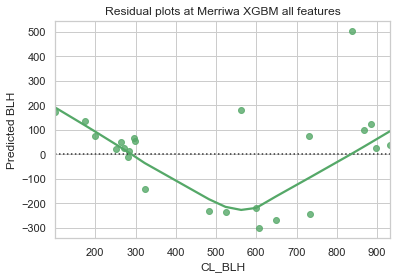

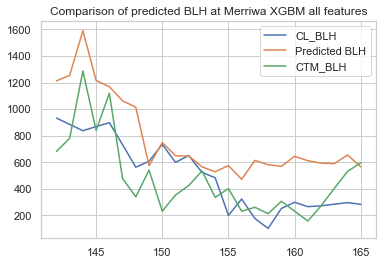

In [80]:
results_print(df_merriwa_xgbm_all, 'Merriwa XGBM all features')

At Lidcombe XGBM all features
Index of agreement:0.63268
Root mean squared error:300.71833
Mean absoluate error:245.21363
Mean bias error:30.65904
DTW distance:3779.69


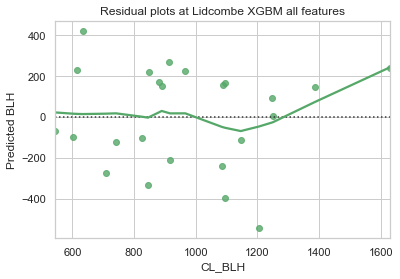

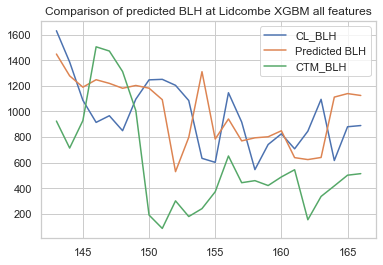

In [81]:
results_print(df_lidcombe_xgbm_all, 'Lidcombe XGBM all features')

<h5>Light GBM</h5>

In [82]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor()

df_merriwa_lgbm_all = modeller(df_merriwa_filled, feature_list_all, 'CL_BLH', lgbm_model)
df_lidcombe_lgbm_all = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', lgbm_model)

At Merriwa LGBM all features
Index of agreement:0.65167
Root mean squared error:362.40321
Mean absoluate error:314.66247
Mean bias error:314.66247
DTW distance:6204.35


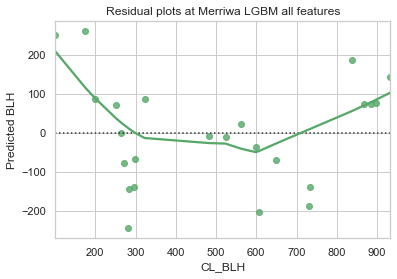

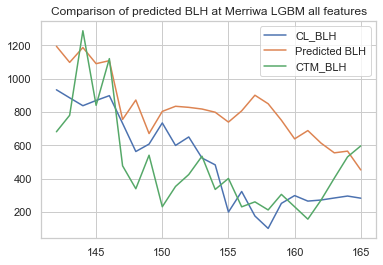

In [83]:
results_print(df_merriwa_lgbm_all, 'Merriwa LGBM all features')

At Lidcombe LGBM all features
Index of agreement:0.69446
Root mean squared error:270.12467
Mean absoluate error:226.50930
Mean bias error:88.98863
DTW distance:4192.09


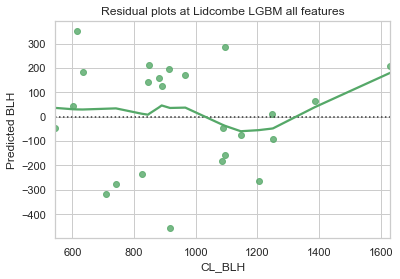

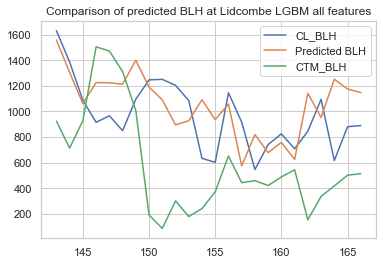

In [84]:
results_print(df_lidcombe_lgbm_all, 'Lidcombe LGBM all features')

<h5>AdaBoost</h5>

In [85]:
from sklearn.ensemble import AdaBoostRegressor

ada_model = AdaBoostRegressor()

df_merriwa_ada_all = modeller(df_merriwa_filled, feature_list_all, 'CL_BLH', ada_model)
df_lidcombe_ada_all = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', ada_model)

At Merriwa ADA all features
Index of agreement:0.74312
Root mean squared error:292.24068
Mean absoluate error:251.56083
Mean bias error:249.59569
DTW distance:4536.39


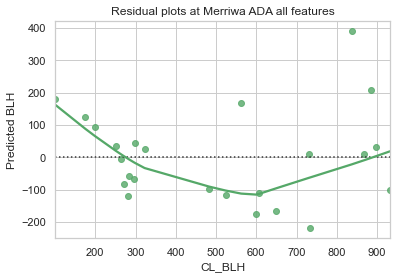

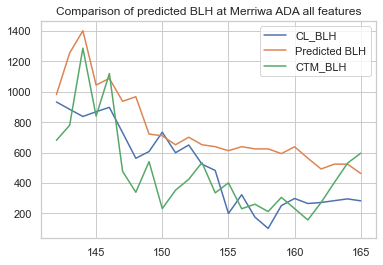

In [86]:
results_print(df_merriwa_ada_all, 'Merriwa ADA all features')

At Lidcombe ADA all features
Index of agreement:0.50124
Root mean squared error:303.56677
Mean absoluate error:248.21897
Mean bias error:134.89045
DTW distance:3652.23


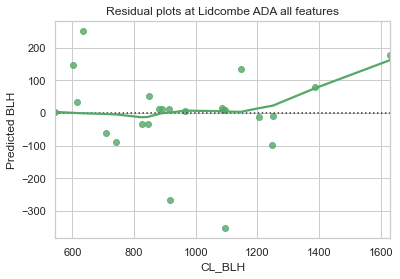

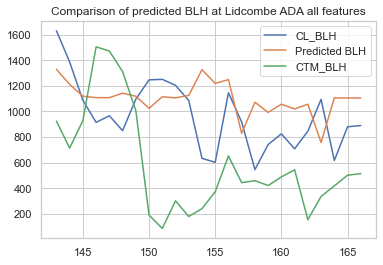

In [87]:
results_print(df_lidcombe_ada_all, 'Lidcombe ADA all features')

<h5>Random forest</h5>

In [88]:
from sklearn.ensemble import RandomForestRegressor

In [89]:
def rf_modeller(df, feature_list, target):
    '''
    Define train test split
    '''
    train = df.head(142)
    test = df.tail(24)
    #These are different periods for Merriwa and Lidcombe!!!
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    '''
    Train model - keep default params
    '''
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    
    '''
    Predict
    '''
    rf_predict = rf.predict(X_test)
    
    '''
    Write to dataframe
    '''
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  rf_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    return df_result, rf

In [90]:
def feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.feature_importances_, index=feature_list)
    feat_importances.nlargest(14).plot(kind='barh')

In [91]:
df_rf_merriwa_all, rf_merriwa_all = rf_modeller(df_merriwa_filled, feature_list_all, 'CL_BLH')

At Merriwa RF all features
Index of agreement:0.74383
Root mean squared error:312.85517
Mean absoluate error:273.29871
Mean bias error:263.78402
DTW distance:5305.02


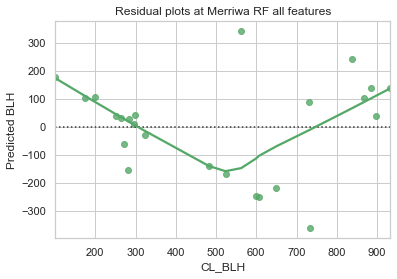

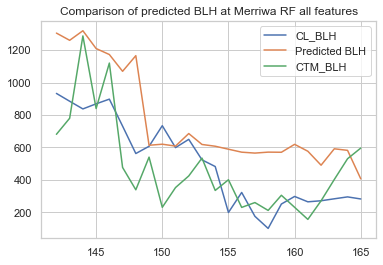

In [92]:
results_print(df_rf_merriwa_all, 'Merriwa RF all features')

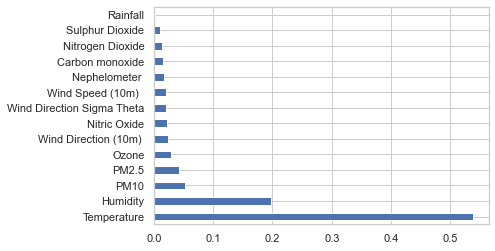

In [93]:
feature_importance_plot(rf_merriwa_all, feature_list_all)

In [94]:
df_rf_lidcombe_all, rf_lidcombe_all = rf_modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH')

At Lidcombe RF all features
Index of agreement:0.63232
Root mean squared error:272.29186
Mean absoluate error:225.87996
Mean bias error:28.15793
DTW distance:3144.57


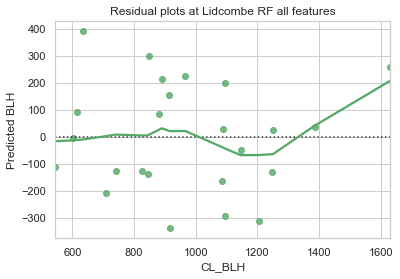

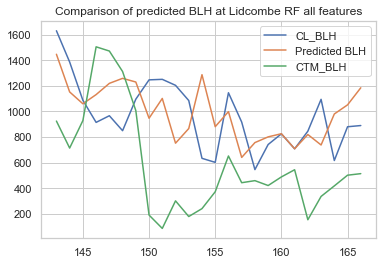

In [95]:
results_print(df_rf_lidcombe_all, 'Lidcombe RF all features')

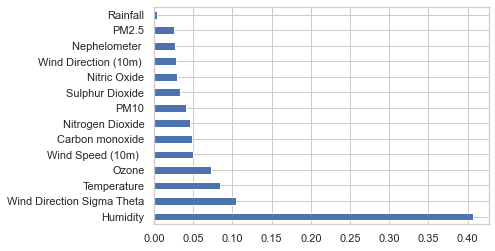

In [96]:
feature_importance_plot(rf_lidcombe_all, feature_list_all)

<h5>Bagging regressor using linear SVR</h5>

In [97]:
from sklearn.ensemble import BaggingRegressor
from sklearn import svm

bagged_SVR_model = BaggingRegressor(base_estimator = svm.LinearSVR())

df_merriwa_svr_all = modeller(df_merriwa_filled, feature_list_all, 'CL_BLH', bagged_SVR_model)
df_lidcombe_svr_all = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', bagged_SVR_model)

C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

At Merriwa SVR all features
Index of agreement:0.63861
Root mean squared error:351.71240
Mean absoluate error:309.45282
Mean bias error:305.06801
DTW distance:5907.41


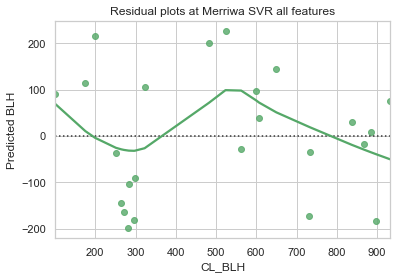

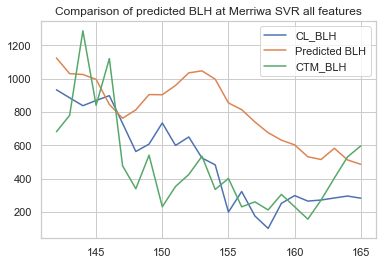

In [99]:
results_print(df_merriwa_svr_all, 'Merriwa SVR all features')

At Lidcombe SVR all features
Index of agreement:0.61050
Root mean squared error:245.52651
Mean absoluate error:187.82494
Mean bias error:-11.11804
DTW distance:3275.40


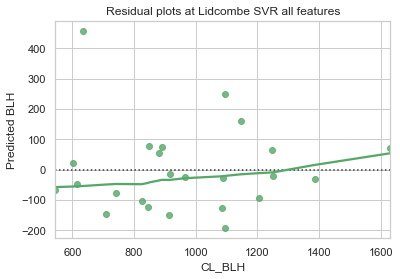

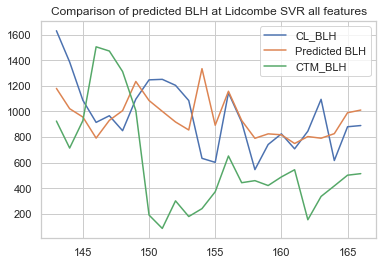

In [100]:
results_print(df_lidcombe_svr_all, 'Lidcombe SVR all features')

<h5>Simple regression model with temp and humidity</h5>

In [119]:
feature_set_1 = ['Temperature', 'Humidity']

In [120]:
'''
Linear regression trainer
'''
from sklearn.linear_model import LinearRegression

def linreg_modeller(df, feature_list, target):
    '''
    Define train test split - drop NA for now. THis is not a good idea I feel... and is not consistent with GBM method
    '''
    train = df.head(142)
    test = df.tail(24)
    #These are different periods for Merriwa and Lidcombe!!!
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    '''
    Train model - keep default params
    '''
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    '''
    Predict
    '''
    lr_predict = lr.predict(X_test)
    
    '''
    Write to dataframe
    '''
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  lr_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    return df_result

In [124]:
df_merriwa_lr_select1 = linreg_modeller(df_merriwa_filled, feature_set_1, 'CL_BLH')
df_lidcombe_lr_select1 = linreg_modeller(df_lidcombe_filled, feature_set_1, 'CL_BLH')

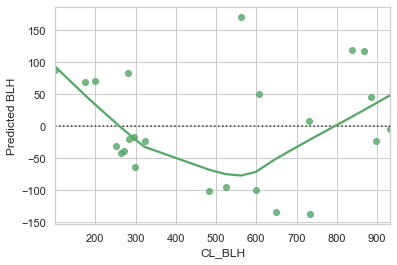

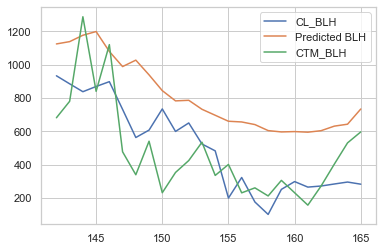

In [122]:
pred_plots(df_merriwa_lr_select1)

In [123]:
satistical_comps_on_df(df_merriwa_lr_select1['CL_BLH'], df_merriwa_lr_select1['Predicted BLH'], 'Merriwa LR select')

At Merriwa LR select
Index of agreement:0.70870
Root mean squared error:326.99635
Mean absoluate error:308.80200
Mean bias error:308.80200
DTW distance:6008.05


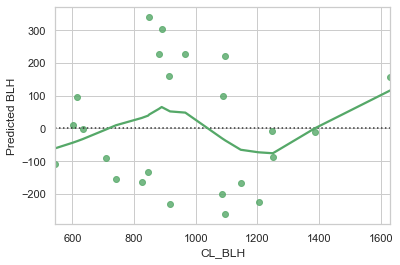

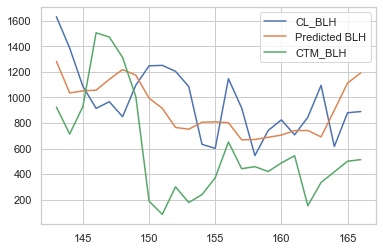

In [125]:
pred_plots(df_lidcombe_lr_select1)

In [126]:
satistical_comps_on_df(df_lidcombe_lr_select1['CL_BLH'], df_lidcombe_lr_select1['Predicted BLH'], 'Lidcombe LR select')

At Lidcombe LR select
Index of agreement:0.64806
Root mean squared error:258.63733
Mean absoluate error:228.76482
Mean bias error:-51.92065
DTW distance:3436.73


ELM?

https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe

https://towardsdatascience.com/introduction-to-extreme-learning-machines-c020020ff82b

<h1>NOT USED - TK PLAY</H1>

<h4>ARIMA</h4>

In [15]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [18]:
auto_arima_merriwa = auto_arima(df_merriwa_cl['CL_BLH'], trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2282.558, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2283.058, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2283.277, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2280.793, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2284.761, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.814 seconds


In [19]:
auto_arima_merriwa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  166
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1139.396
Date:                Thu, 29 Jul 2021   AIC                           2280.793
Time:                        11:54:18   BIC                           2283.899
Sample:                             0   HQIC                          2282.054
                                - 166                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.841e+04   4885.664     11.955      0.000    4.88e+04     6.8e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.61   Jarque-Bera (JB):                15.07
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
arima_merriwa = ARIMA(df_merriwa_cl['CL_BLH'], order=(0,1,0))
print(arima_merriwa.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                 CL_BLH   No. Observations:                  166
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1139.396
Date:                Thu, 29 Jul 2021   AIC                           2280.793
Time:                        11:54:22   BIC                           2283.899
Sample:                             0   HQIC                          2282.054
                                - 166                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.841e+04   4885.664     11.955      0.000    4.88e+04     6.8e+04
Ljung-Box (L1) (Q):                   1.61   Jarque-Bera (JB):                15.07
Prob(Q):                              0.20   Pr

Cool. What does this mean?
How to use auto_arima to get params right?

Trad TS models lack the ability to fit causal relationships easily. Could extend this by predicting the predictors but that would require first feature selection.

Perhaps this could be briefly tried?

<h4>Regression models</h4>

Some considerations:
* p value selection vs backward/forward selection
* what is train test split given only 1 week data...?
* regression on whole data since we want a generic feature selection for BL?
* Test on individual sites?

<h5>Train test split</h5>
Without preserving the relative order of time stamps

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
#Extract features
feature_list = [feature for feature in df_merriwa.columns][4:len(df_merriwa.columns)-1]
feature_list

['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Nitric Oxide',
 'Nitrogen Dioxide',
 'Ozone',
 'PM10',
 'PM2.5',
 'Rainfall',
 'Sulphur Dioxide',
 'Temperature',
 'Wind Direction (10m) ',
 'Wind Direction Sigma Theta',
 'Wind Speed (10m)  ']

In [19]:
#Train test split on both Merriwa and Lidcombe - assuming actual BLH as target, drop na

X_train_merriwa, X_test_merriwa, y_train_merriwa, y_test_merriwa = train_test_split(df_merriwa.dropna()[feature_list], df_merriwa.dropna()['CL_BLH'], test_size=0.3, random_state=42)
X_train_lidcombe, X_test_lidcombe, y_train_lidcombe, y_test_lidcombe = train_test_split(df_lidcombe.dropna()[feature_list], df_lidcombe.dropna()['CL_BLH'], test_size=0.3, random_state=42)

#Combine the train sets into one unified train set
X_train = X_train_merriwa.append(X_train_lidcombe)
y_train = y_train_merriwa.append(y_train_lidcombe)

#Retain NAs somehow maybe?

In [50]:
#sanity check
print(X_train.shape, y_train.shape)

(191, 14) (191,)


<h5>Simple lin reg</h5>

Based on p-value factors: CO2, humidity, nephelometer, O3, temp, wind dir sigma and solar radiation

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
lin_reg_feature = ['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Ozone',
 'Temperature',
 'Wind Direction Sigma Theta']

In [51]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin_reg_merriwa = pd.DataFrame(lin_reg.predict(X_test_merriwa))
y_pred_lin_reg_lidcombe = pd.DataFrame(lin_reg.predict(X_test_lidcombe))


In [50]:
satistical_comps_on_df(y_test_merriwa, y_pred_lin_reg_merriwa, 'Merriwa')

At Merriwa
Index of agreement:0.38503
Root mean squared error:313.04817
Mean absoluate error:232.16030
Mean bias error:31.07479
DTW distance:8581.86


In [52]:
satistical_comps_on_df(y_test_lidcombe, y_pred_lin_reg_lidcombe, 'Lidcombe')

At Lidcombe
Index of agreement:0.37885
Root mean squared error:330.31921
Mean absoluate error:268.77703
Mean bias error:6.16069
DTW distance:9540.98


<h5>SVR</h5>

In [32]:
from sklearn import svm

def svr_modeller(df, feature_list, target):
    '''
    Define train test split - drop NA for now. THis is not a good idea I feel... and is not consistent with GBM method
    '''
    train = df.head(142).dropna()
    test = df.tail(24).dropna()
    #These are different periods for Merriwa and Lidcombe!!!
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    '''
    Train model - keep default params
    '''
    svr = svm.LinearSVR()
    svr.fit(X_train, y_train)
    
    '''
    Predict
    '''
    svr_predict = svr.predict(X_test)
    
    '''
    Write to dataframe
    '''
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  svr_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    return df_result

In [33]:
df_merriwa_svr_all = svr_modeller(df_merriwa, feature_list_all, 'CL_BLH')

C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
